<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/O2_prediction_model_Network_C_v2_O2T_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPIE Proceedings code

## Dataset 2

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

# Keras

from tensorflow.keras.models import Sequential

#from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras import layers
import tensorflow.keras as keras

from keras.utils.vis_utils import plot_model

import tensorflow.keras.backend as K

from numpy import random

from scipy.interpolate import interp1d

from matplotlib.lines import Line2D

from matplotlib.patches import Patch

import seaborn as sns

Using TensorFlow backend.


# Read the files (Google Drive)

In [350]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [351]:
train_data_df = pd.read_csv('../data/train_data2.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets2.csv', names=['T', 'O2'], header = None)

# Read the files (Local files)

In [2]:
train_data_df = pd.read_csv('../data/train_data2.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets2.csv', names=['T', 'O2'], header = None)

In [3]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.535241,0.537692,0.537186,0.539902,0.54284,0.544292,0.546761,0.549564,0.552743,0.560122,...,0.790886,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
1,0.536566,0.536806,0.538521,0.540439,0.54239,0.544292,0.546761,0.549256,0.552183,0.559891,...,0.790804,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
2,0.536566,0.537692,0.537186,0.540439,0.54239,0.544292,0.546418,0.549256,0.552463,0.560122,...,0.790969,0.795041,0.799099,0.802755,0.806522,0.820096,0.832059,0.842727,0.85205,0.860323
3,0.536566,0.536806,0.539188,0.541512,0.54194,0.544681,0.546761,0.549256,0.552743,0.560122,...,0.790969,0.795041,0.799099,0.802918,0.806522,0.820096,0.832059,0.842571,0.85205,0.860323
4,0.537891,0.537692,0.537853,0.540439,0.54284,0.544292,0.547104,0.549564,0.552463,0.560582,...,0.790969,0.795041,0.799017,0.802837,0.806522,0.820255,0.832059,0.842727,0.85205,0.860552


In [4]:
train_target_df.head()

,T,O2
0,20.0,35.0
1,20.0,35.0
2,20.0,35.0
3,20.0,35.0
4,20.0,35.0


In [5]:
train_target_df[['O2']] = train_target_df[['O2']]/100.0
train_target_df[['T']] = train_target_df[['T']]/45.0

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [6]:
print(train_target_df['T'].unique())
print(train_target_df['T'].unique()*45)

[0.44444444 0.55555556 0.22222222 0.66666667 0.77777778 0.33333333
 0.88888889 1.         0.11111111]
[20. 25. 10. 30. 35. 15. 40. 45.  5.]


## Remove the records for [O2] = 0

In [7]:
train_data_df.shape

(3780, 50)

In [8]:
train_data_df[train_target_df['O2'] == 0].shape

(180, 50)

In [9]:
train_data_df.drop(train_data_df[train_target_df['O2'] == 0].index, inplace=True)
train_target_df.drop(train_target_df[train_target_df['O2'] == 0].index, inplace=True)
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);
print(train_data_df.shape)

(3600, 50)


## Dimensions

In [10]:
train_data_df.shape

(3600, 50)

In [11]:
train_target_df[train_target_df['T'] == 5./45.].shape

(400, 2)

To check how many values we have for each temperature we can do easily with ```groupby()```.

In [12]:
train_target_df.groupby('T')['O2'].nunique()

T
0.111111    20
0.222222    20
0.333333    20
0.444444    20
0.555556    20
0.666667    20
0.777778    20
0.888889    20
1.000000    20
Name: O2, dtype: int64

Each of the temperature has 5000 observations.

## Reset the index

In [13]:
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [14]:
np.unique(train_target_df['T'])*45

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

# Frequency values

In [15]:
wred = [  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.]

# Some plots

In [16]:
train_data_df[train_target_df['O2'] == 35/100.0]

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.535241,0.537692,0.537186,0.539902,0.542840,0.544292,0.546761,0.549564,0.552743,0.560122,...,0.790886,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
1,0.536566,0.536806,0.538521,0.540439,0.542390,0.544292,0.546761,0.549256,0.552183,0.559891,...,0.790804,0.794876,0.798935,0.802755,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
2,0.536566,0.537692,0.537186,0.540439,0.542390,0.544292,0.546418,0.549256,0.552463,0.560122,...,0.790969,0.795041,0.799099,0.802755,0.806522,0.820096,0.832059,0.842727,0.852050,0.860323
3,0.536566,0.536806,0.539188,0.541512,0.541940,0.544681,0.546761,0.549256,0.552743,0.560122,...,0.790969,0.795041,0.799099,0.802918,0.806522,0.820096,0.832059,0.842571,0.852050,0.860323
4,0.537891,0.537692,0.537853,0.540439,0.542840,0.544292,0.547104,0.549564,0.552463,0.560582,...,0.790969,0.795041,0.799017,0.802837,0.806522,0.820255,0.832059,0.842727,0.852050,0.860552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1755,0.554487,0.556040,0.557223,0.558001,0.560329,0.563077,0.566402,0.568445,0.571639,0.580336,...,0.813382,0.817335,0.820904,0.824531,0.827871,0.840492,0.851455,0.861019,0.869404,0.876933
1756,0.553247,0.556040,0.556598,0.558505,0.560329,0.562712,0.565758,0.568734,0.571902,0.580336,...,0.813382,0.817335,0.820984,0.824531,0.827871,0.840492,0.851455,0.861019,0.869404,0.876933
1757,0.554487,0.555210,0.557849,0.558505,0.560752,0.562712,0.565436,0.568734,0.571902,0.580553,...,0.813382,0.817254,0.820984,0.824611,0.827871,0.840492,0.851455,0.861019,0.869480,0.876933
1758,0.554487,0.556040,0.557223,0.558505,0.560329,0.563077,0.565436,0.568734,0.571639,0.580336,...,0.813382,0.817254,0.820984,0.824611,0.827951,0.840492,0.851455,0.861019,0.869480,0.876933


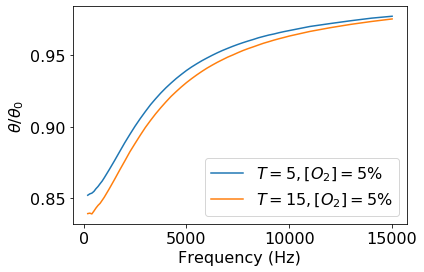

In [17]:
plt.plot(wred, train_data_df[(train_target_df['O2'] == 5./100.0) & (train_target_df['T'] == 5./45.0)].iloc[0], label ='$T=5, [O_2]=5 \%$')
plt.plot(wred, train_data_df[(train_target_df['O2'] == 5./100.0) & (train_target_df['T'] == 15./45.0)].iloc[0], label ='$T=15, [O_2]=5 \%$')
plt.tick_params(labelsize=16)
plt.legend(fontsize = 16)
plt.xlabel ('Frequency (Hz)', fontsize = 16)
plt.ylabel (r'$\theta / \theta_0$', fontsize = 16)
plt.show()

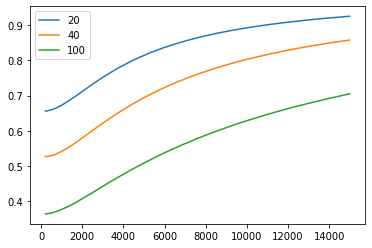

In [18]:
#plt.plot(wred, train_data_df[train_target_df['O2'] == 0/100.0].iloc[0], label ='0')
plt.plot(wred, train_data_df[train_target_df['O2'] == 20/100.0].iloc[0], label ='20')
plt.plot(wred, train_data_df[train_target_df['O2'] == 40/100.0].iloc[0], label ='40')
plt.plot(wred, train_data_df[train_target_df['O2'] == 100/100.0].iloc[0], label ='100')
plt.legend()
plt.show()

# Dataset split

In [19]:
np.random.seed(42)
rnd = np.random.rand(len(train_target_df)) < 0.8

In [20]:
data_train = train_data_df[rnd]
data_dev = train_data_df[~rnd]
targets_train = train_target_df[rnd]
targets_dev = train_target_df[~rnd]

In [21]:
np.min(np.min(data_train))

0.3324222501292755

In [22]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (2880, 50)
Number of dev      data observations is  (720, 50)


# Plot 1

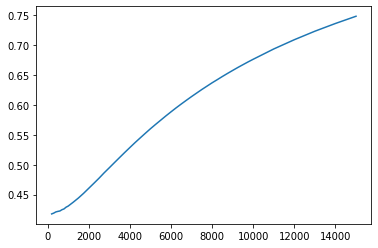

In [25]:
plt.plot(wred, train_data_df.iloc[200])

## Helper Functions

In [26]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks


def MAE_T_list_generator_w0(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0) & (targets_dev['O2'] > 0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [27]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [28]:
# Get predictions
def get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [29]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 5000 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return
        
class CustomCallbackProgress(keras.callbacks.Callback):
    
    def __init__(self, totalEpochs, step):
        self.step = 0
        self.totalEpochs = totalEpochs
        self.step = step
        
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 200 == 0):
            i = int(epoch / 200)
            
            if (i > 0):
                numberOfEquals = int(self.totalEpochs/200*i)
                percent = 100/(self.totalEpochs/200)*i
            else:
                numberOfEquals = 0
                percent = 0
                
                
            print ("\r[%-20s] %d%%" % ('='*i, percent), end='')
            
            if(percent == 100):
                print('')
        

In [30]:
def reset_keras():
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [31]:
def average_runs(n_iter, model_):
    MAE_O2_boxplot_avg = [0]*9
    MAE_T_boxplot_avg = [0]*5

    for i in range(n_iter):
        print ("Training iteration ", i)
        
        model_.fit(data_train, targets_train, epochs=4001, batch_size=1000,verbose = 0,
             validation_data= (data_dev, targets_dev), callbacks = [CustomCallbackProgress(4000,200)])

        print("Getting predictions for iteration ",i)
        targets_dev_, preds_df_ = get_predictions(model_, targets_dev, data_dev)
        targets_train_, preds_train_ = get_predictions(model_, targets_train, data_train)

        print("Generating MAE lists for iteration ", i)
        MAE_boxplot_, MAE_list_, MAE_xticks_ = MAE_O2_list_generator(10.0, targets_dev_, preds_df_)
        MAE_T_boxplot_, MAE_T_list_, MAE_T_xticks_ = MAE_T_list_generator(targets_dev_, preds_df_)
        #MAE_boxplot_train_, MAE_list_train_, MAE_xticks_train_ = MAE_list_generator(10.0, targets_train_, preds_train_)

        for j in range(len(MAE_boxplot_)):
            MAE_O2_boxplot_avg[j] = MAE_O2_boxplot_avg[j] + np.array(MAE_boxplot_[j])/n_iter
            
        for j in range(len(MAE_T_boxplot_)):
            MAE_T_boxplot_avg[j] = MAE_T_boxplot_avg[j] + np.array(MAE_T_boxplot_[j])/n_iter

    return MAE_O2_boxplot_avg, MAE_T_boxplot_avg

In [32]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

# Random Seed to get reproducible results

In [33]:
K.clear_session()

from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
#set_random_seed(42)

# Network C

In [34]:
class CustomCallback_(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 5000 == 0):
            print ("Just finished epoch", epoch)
            #print(logs)
            print ("Validation MAE_O2 = ", 100*float(logs.get("val_O2_output_mae")))
            print ("Validation MAE_T = ", 45*float(logs.get("val_T_output_mae")))
            print ("Training   MAE_O2 = ", 100*float(logs.get("O2_output_mae")))
            print ("Training   MAE_T = ", 45*float(logs.get("T_output_mae")))
            
            return

In [151]:
K.clear_session()

In [35]:
def get_compiled_model(input_freqs = 50):
    input_x = keras.layers.Input(shape = (input_freqs,))
    lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
    lay2 = layers.Dense(50, activation='sigmoid')(lay1)
    lay3 = layers.Dense(50, activation='sigmoid')(lay2)
    outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

    lay4 = layers.Dense(5, activation='sigmoid')(lay3)
    lay5 = layers.Dense(5, activation='sigmoid')(lay4)
    outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


    lay6 = layers.Dense(5, activation='sigmoid')(lay3)
    lay7 = layers.Dense(5, activation='sigmoid')(lay6)
    outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

    #model = Model(input_x, outl)

    model4 = Model(
        inputs=input_x,
        outputs=[outboth, outo2, outT])
    
    losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
    }

    #0.3, 5, 5
    lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

    opt = Adam(lr=0.001)

    model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
            metrics=["mae"])
    
    return model4

In [36]:
targets_train_O2 = targets_train['O2']
targets_dev_O2 = targets_dev['O2']
targets_train_T = targets_train['T']
targets_dev_T = targets_dev['T']

## Fitting of the model - removing 5 frequency from left

In [51]:
data_train_red = np.zeros((data_train.shape[0], 45))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][5:]
    
data_dev_red = np.zeros((data_dev.shape[0], 45))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][5:]

In [52]:
model4 = get_compiled_model(45)

In [55]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.200871467590332, 'both_output_loss': 0.092686355, 'O2_output_loss': 0.08971767, 'T_output_loss': 0.14489543, 'both_output_mae': 0.25845134, 'O2_output_mae': 0.2559963, 'T_output_mae': 0.3121305, 'val_loss': 1.1574009656906128, 'val_both_output_loss': 0.09113793, 'val_O2_output_loss': 0.08647701, 'val_T_output_loss': 0.1395349, 'val_both_output_mae': 0.25758725, 'val_O2_output_mae': 0.25311708, 'val_T_output_mae': 0.30462444}
Just finished epoch 5000
{'loss': 0.0192289799451828, 'both_output_loss': 0.0038283027, 'O2_output_loss': 0.0003354334, 'T_output_loss': 0.003280664, 'both_output_mae': 0.041451655, 'O2_output_mae': 0.011753869, 'T_output_mae': 0.042843856, 'val_loss': 0.020876498892903328, 'val_both_output_loss': 0.0038572473, 'val_O2_output_loss': 0.00031988684, 'val_T_output_loss': 0.0036239782, 'val_both_output_mae': 0.039926343, 'val_O2_output_mae': 0.012308174, 'val_T_output_mae': 0.045329493}
Just finished epoch 10000
{'loss': 0.0084410617128

In [61]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus5.h5")

In [57]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [58]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [59]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [60]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

0.2791318690431294
0.7421202353305285


## Fitting of the model - removing 10 frequency from left

In [64]:
rem = 10
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [65]:
model4 = get_compiled_model(50-rem)

In [66]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 0.9148028492927551, 'both_output_loss': 0.096408725, 'O2_output_loss': 0.08403436, 'T_output_loss': 0.09314169, 'both_output_mae': 0.2628823, 'O2_output_mae': 0.25038612, 'T_output_mae': 0.25867882, 'val_loss': 0.9010629653930664, 'val_both_output_loss': 0.09532103, 'val_O2_output_loss': 0.08274113, 'val_T_output_loss': 0.0917522, 'val_both_output_mae': 0.2609089, 'val_O2_output_mae': 0.24885286, 'val_T_output_mae': 0.25704187}
Just finished epoch 5000
{'loss': 0.03636881709098816, 'both_output_loss': 0.009243281, 'O2_output_loss': 0.00045430858, 'T_output_loss': 0.006264858, 'both_output_mae': 0.06506565, 'O2_output_mae': 0.015276389, 'T_output_mae': 0.052907113, 'val_loss': 0.03771088272333145, 'val_both_output_loss': 0.009012116, 'val_O2_output_loss': 0.00043588664, 'val_T_output_loss': 0.006565563, 'val_both_output_mae': 0.06450452, 'val_O2_output_mae': 0.015198178, 'val_T_output_mae': 0.052761205}
Just finished epoch 10000
{'loss': 0.0144526809453964

In [67]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus10.h5")

In [68]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [69]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [70]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [71]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

0.47368976322637063
1.5087105477125278


## Fitting of the model - removing 15 frequency from left

In [72]:
rem = 15
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [73]:
model4 = get_compiled_model(50-rem)

In [74]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.0049159526824951, 'both_output_loss': 0.12118503, 'O2_output_loss': 0.0981745, 'T_output_loss': 0.09553759, 'both_output_mae': 0.28791863, 'O2_output_mae': 0.2648927, 'T_output_mae': 0.26065683, 'val_loss': 1.0226120948791504, 'val_both_output_loss': 0.11903518, 'val_O2_output_loss': 0.09842968, 'val_T_output_loss': 0.09895062, 'val_both_output_mae': 0.2861517, 'val_O2_output_mae': 0.26330134, 'val_T_output_mae': 0.26509437}
Just finished epoch 5000
{'loss': 0.05669074505567551, 'both_output_loss': 0.016591705, 'O2_output_loss': 0.00073913735, 'T_output_loss': 0.00960351, 'both_output_mae': 0.09175797, 'O2_output_mae': 0.018682536, 'T_output_mae': 0.06306, 'val_loss': 0.055391982197761536, 'val_both_output_loss': 0.01643286, 'val_O2_output_loss': 0.0007154478, 'val_T_output_loss': 0.009376977, 'val_both_output_mae': 0.09166871, 'val_O2_output_mae': 0.018850036, 'val_T_output_mae': 0.05927908}
Just finished epoch 10000
{'loss': 0.0378098227083683, 'both_

In [75]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus15.h5")

In [76]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [77]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [78]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [79]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

1.1267520682751266
2.3284462326102786


## Fitting of the model - removing 25 frequency from left

In [80]:
rem = 25
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [81]:
model4 = get_compiled_model(50-rem)

In [82]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 0.8634994029998779, 'both_output_loss': 0.10633177, 'O2_output_loss': 0.08404594, 'T_output_loss': 0.082274035, 'both_output_mae': 0.27314737, 'O2_output_mae': 0.25042808, 'T_output_mae': 0.24774458, 'val_loss': 0.8616530895233154, 'val_both_output_loss': 0.1026797, 'val_O2_output_loss': 0.0827441, 'val_T_output_loss': 0.08342574, 'val_both_output_mae': 0.27067283, 'val_O2_output_mae': 0.24881066, 'val_T_output_mae': 0.25138697}
Just finished epoch 5000
{'loss': 0.39769721031188965, 'both_output_loss': 0.038631205, 'O2_output_loss': 0.00460317, 'T_output_loss': 0.0726184, 'both_output_mae': 0.1416188, 'O2_output_mae': 0.05344982, 'T_output_mae': 0.22967707, 'val_loss': 0.4054054617881775, 'val_both_output_loss': 0.039417908, 'val_O2_output_loss': 0.0048037292, 'val_T_output_loss': 0.073912285, 'val_both_output_mae': 0.14424473, 'val_O2_output_mae': 0.055493154, 'val_T_output_mae': 0.23257972}
Just finished epoch 10000
{'loss': 0.3899320065975189, 'both_ou

In [83]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus25.h5")

In [84]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [85]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [86]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [87]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

4.910872258893821
9.943648681044579


## Fitting of the model - removing 35 frequency from left

In [90]:
rem = 35
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [91]:
model4 = get_compiled_model(50-rem)

In [92]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.0167862176895142, 'both_output_loss': 0.10249762, 'O2_output_loss': 0.111366145, 'T_output_loss': 0.08584125, 'both_output_mae': 0.26908004, 'O2_output_mae': 0.27824447, 'T_output_mae': 0.253041, 'val_loss': 1.0321533679962158, 'val_both_output_loss': 0.10157641, 'val_O2_output_loss': 0.11182785, 'val_T_output_loss': 0.08850823, 'val_both_output_mae': 0.26951, 'val_O2_output_mae': 0.27700952, 'val_T_output_mae': 0.2578583}
Just finished epoch 5000
{'loss': 0.3829619288444519, 'both_output_loss': 0.03858964, 'O2_output_loss': 0.0047793565, 'T_output_loss': 0.06949765, 'both_output_mae': 0.14186914, 'O2_output_mae': 0.054842927, 'T_output_mae': 0.22149985, 'val_loss': 0.3857157528400421, 'val_both_output_loss': 0.03924714, 'val_O2_output_loss': 0.004978705, 'val_T_output_loss': 0.069809616, 'val_both_output_mae': 0.14415003, 'val_O2_output_mae': 0.056687213, 'val_T_output_mae': 0.22360997}
Just finished epoch 10000
{'loss': 0.3669218122959137, 'both_outpu

In [93]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus35.h5")

In [94]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [95]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [96]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [97]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

4.668047012194343
8.333336919753087


## Fitting of the model - removing 45 frequency from left

In [101]:
rem = 45
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [102]:
model4 = get_compiled_model(50-rem)

In [103]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 0.9780373573303223, 'both_output_loss': 0.099575065, 'O2_output_loss': 0.093484454, 'T_output_loss': 0.09614851, 'both_output_mae': 0.2664992, 'O2_output_mae': 0.26029724, 'T_output_mae': 0.26150757, 'val_loss': 0.9763631820678711, 'val_both_output_loss': 0.098007955, 'val_O2_output_loss': 0.089700155, 'val_T_output_loss': 0.099692, 'val_both_output_mae': 0.26609057, 'val_O2_output_mae': 0.2568089, 'val_T_output_mae': 0.26613826}
Just finished epoch 5000
{'loss': 0.3919069766998291, 'both_output_loss': 0.03852366, 'O2_output_loss': 0.00500246, 'T_output_loss': 0.07106752, 'both_output_mae': 0.14198464, 'O2_output_mae': 0.05555652, 'T_output_mae': 0.22628745, 'val_loss': 0.3998323082923889, 'val_both_output_loss': 0.039345764, 'val_O2_output_loss': 0.00520876, 'val_T_output_loss': 0.07239696, 'val_both_output_mae': 0.14449474, 'val_O2_output_mae': 0.057458147, 'val_T_output_mae': 0.22990999}
Just finished epoch 10000
{'loss': 0.36743614077568054, 'both_out

In [104]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus45.h5")

In [105]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [106]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [107]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [108]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

5.554679946838945
9.613256932443214


## Fitting of the model - removing 7 frequency from left

In [119]:
rem = 7
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [120]:
model4 = get_compiled_model(50-rem)

In [121]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.1999057531356812, 'both_output_loss': 0.10107125, 'O2_output_loss': 0.08416575, 'T_output_loss': 0.14975113, 'both_output_mae': 0.26770222, 'O2_output_mae': 0.25030816, 'T_output_mae': 0.31744197, 'val_loss': 1.1608822345733643, 'val_both_output_loss': 0.10091255, 'val_O2_output_loss': 0.08201501, 'val_T_output_loss': 0.14410667, 'val_both_output_mae': 0.2676072, 'val_O2_output_mae': 0.24883059, 'val_T_output_mae': 0.30974993}
Just finished epoch 5000
{'loss': 0.03146260604262352, 'both_output_loss': 0.010257579, 'O2_output_loss': 0.00063437916, 'T_output_loss': 0.0050426875, 'both_output_mae': 0.06831045, 'O2_output_mae': 0.017696016, 'T_output_mae': 0.04924418, 'val_loss': 0.031423427164554596, 'val_both_output_loss': 0.01009516, 'val_O2_output_loss': 0.0006428183, 'val_T_output_loss': 0.0050361576, 'val_both_output_mae': 0.06838381, 'val_O2_output_mae': 0.017572302, 'val_T_output_mae': 0.048626475}
Just finished epoch 10000
{'loss': 0.014693617820739

In [122]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus7.h5")

In [123]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [124]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [125]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [126]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

0.4873437271385951
1.387355142273009


## Fitting of the model - removing 20 frequency from left

In [130]:
rem = 20
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [131]:
model4 = get_compiled_model(50-rem)

In [132]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 0.9498193264007568, 'both_output_loss': 0.14357921, 'O2_output_loss': 0.09743093, 'T_output_loss': 0.08391818, 'both_output_mae': 0.30960277, 'O2_output_mae': 0.26400504, 'T_output_mae': 0.25104806, 'val_loss': 0.9388054609298706, 'val_both_output_loss': 0.13730769, 'val_O2_output_loss': 0.09329406, 'val_T_output_loss': 0.08622858, 'val_both_output_mae': 0.30284214, 'val_O2_output_mae': 0.2601205, 'val_T_output_mae': 0.25572067}
Just finished epoch 5000
{'loss': 0.3707002103328705, 'both_output_loss': 0.038570594, 'O2_output_loss': 0.0042321105, 'T_output_loss': 0.067593694, 'both_output_mae': 0.14073172, 'O2_output_mae': 0.05134132, 'T_output_mae': 0.21608844, 'val_loss': 0.37725985050201416, 'val_both_output_loss': 0.039220687, 'val_O2_output_loss': 0.004412913, 'val_T_output_loss': 0.068685815, 'val_both_output_mae': 0.14320152, 'val_O2_output_mae': 0.05328043, 'val_T_output_mae': 0.22004335}
Just finished epoch 10000
{'loss': 0.09854865074157715, 'bot

In [133]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus20.h5")

In [134]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [135]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [136]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [137]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

1.42281527687674
2.969150837821265


## Fitting of the model - removing 22 frequency from left

In [147]:
rem = 22
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [148]:
model4 = get_compiled_model(50-rem)

In [149]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.1150413751602173, 'both_output_loss': 0.08773716, 'O2_output_loss': 0.13552576, 'T_output_loss': 0.082218274, 'both_output_mae': 0.25439152, 'O2_output_mae': 0.30223185, 'T_output_mae': 0.24786676, 'val_loss': 1.1311790943145752, 'val_both_output_loss': 0.08693855, 'val_O2_output_loss': 0.13700956, 'val_T_output_loss': 0.084009945, 'val_both_output_mae': 0.25502098, 'val_O2_output_mae': 0.30242267, 'val_T_output_mae': 0.25237343}
Just finished epoch 5000
{'loss': 0.34646227955818176, 'both_output_loss': 0.03694178, 'O2_output_loss': 0.0043007056, 'T_output_loss': 0.06277524, 'both_output_mae': 0.13917848, 'O2_output_mae': 0.052285433, 'T_output_mae': 0.2117023, 'val_loss': 0.3389263153076172, 'val_both_output_loss': 0.037857316, 'val_O2_output_loss': 0.004418564, 'val_T_output_loss': 0.06109526, 'val_both_output_mae': 0.14192693, 'val_O2_output_mae': 0.053715315, 'val_T_output_mae': 0.2081979}
Just finished epoch 10000
{'loss': 0.11859593540430069, 'bot

In [150]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus22.h5")

In [151]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [152]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [153]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [154]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

2.07082756533139
3.8644917716996536


## Fitting of the model - removing 23 frequency from left

In [160]:
rem = 23
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [161]:
model4 = get_compiled_model(50-rem)

In [162]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.2804274559020996, 'both_output_loss': 0.1071552, 'O2_output_loss': 0.13111341, 'T_output_loss': 0.11854277, 'both_output_mae': 0.27465072, 'O2_output_mae': 0.29781044, 'T_output_mae': 0.28518, 'val_loss': 1.2719433307647705, 'val_both_output_loss': 0.10398227, 'val_O2_output_loss': 0.124708876, 'val_T_output_loss': 0.12344085, 'val_both_output_mae': 0.26960766, 'val_O2_output_mae': 0.29098287, 'val_T_output_mae': 0.2919136}
Just finished epoch 5000
{'loss': 0.32514169812202454, 'both_output_loss': 0.036188014, 'O2_output_loss': 0.003907125, 'T_output_loss': 0.058949932, 'both_output_mae': 0.13678376, 'O2_output_mae': 0.050161604, 'T_output_mae': 0.20306854, 'val_loss': 0.3263731598854065, 'val_both_output_loss': 0.036759607, 'val_O2_output_loss': 0.004018067, 'val_T_output_loss': 0.05905099, 'val_both_output_mae': 0.13908623, 'val_O2_output_mae': 0.051495727, 'val_T_output_mae': 0.20547697}
Just finished epoch 10000
{'loss': 0.09735587984323502, 'both_o

In [163]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus23.h5")

In [164]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [165]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [166]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [167]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

2.1271948862982835
3.3168328680201538


## Fitting of the model - Without removing any points

In [195]:
rem = 0
data_train_red = np.zeros((data_train.shape[0], 50-rem))
for i in range(data_train.shape[0]):
    data_train_red[i] = np.array(data_train)[i][rem:]
    
data_dev_red = np.zeros((data_dev.shape[0], 50-rem))
for i in range(data_dev.shape[0]):
    data_dev_red[i] = np.array(data_dev)[i][rem:]

In [196]:
model4 = get_compiled_model(50-rem)

In [197]:
H = model4.fit(data_train_red,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev_red,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 4000,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.265343427658081, 'both_output_loss': 0.16191745, 'O2_output_loss': 0.15237832, 'T_output_loss': 0.09097531, 'both_output_mae': 0.32891333, 'O2_output_mae': 0.31917754, 'T_output_mae': 0.2566379, 'val_loss': 1.2458102703094482, 'val_both_output_loss': 0.16124193, 'val_O2_output_loss': 0.14530294, 'val_T_output_loss': 0.0941846, 'val_both_output_mae': 0.32895076, 'val_O2_output_mae': 0.31192812, 'val_T_output_mae': 0.2616427}
Just finished epoch 5000
{'loss': 0.009422329254448414, 'both_output_loss': 0.0016194589, 'O2_output_loss': 0.0002418453, 'T_output_loss': 0.0015454531, 'both_output_mae': 0.02787824, 'O2_output_mae': 0.009676959, 'T_output_mae': 0.030539487, 'val_loss': 0.010674282908439636, 'val_both_output_loss': 0.0018250628, 'val_O2_output_loss': 0.00022367504, 'val_T_output_loss': 0.0018016779, 'val_both_output_mae': 0.028817536, 'val_O2_output_mae': 0.009732929, 'val_T_output_mae': 0.03352976}
Just finished epoch 10000
{'loss': 0.0038893497548

In [198]:
model4.save("model_20000_4000_1e-3_3x50_2x5_2x5_theta_theta0_minus0.h5")

In [199]:
(O2T, O2, T) = model4.predict(data_dev_red)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [200]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [201]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)
MAET_boxplot_C_MTL_w0, MAET_list_C_MTL_w0, MAET_xticks_C_MTL_w0 = MAE_T_list_generator_w0(targets_dev, preds_exp_T_df)

MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]

In [202]:
print(np.mean(MAE_boxplot_C_flat))
print(np.mean(MAET_boxplot_C_MTL_flat))

0.2826865116755171
0.6523985517107777


## KDE Plot

In [225]:
m_ = np.mean(MAE_boxplot_C_flat)
m_

0.2826865116755171

In [226]:
np.mean(MAET_boxplot_C_MTL_flat)

0.6523985517107777

<Figure size 432x288 with 0 Axes>

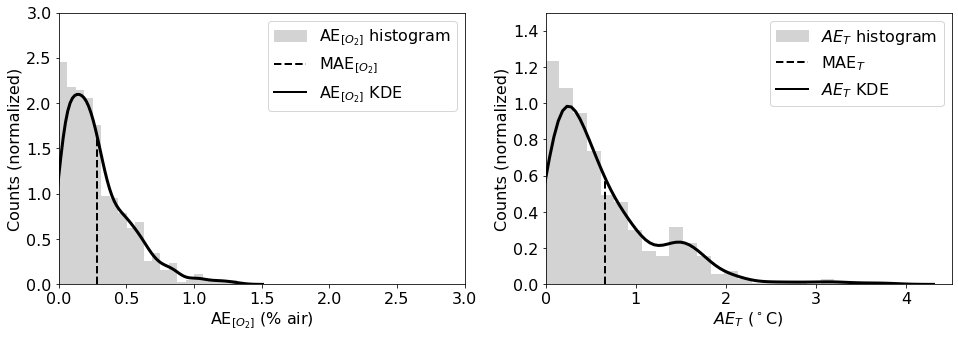

W0227 20:52:39.419210 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.419868 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.485466 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.486099 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.721524 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.722203 4534033856 backend_ps.py:804] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
W0227 20:52:39.782988 4534033856 b

In [222]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "lightgray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})


custom_lines = [Patch(facecolor='lightgray', edgecolor='lightgray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='black', lw=2, ls = '--'),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ histogram', 'MAE$_{[O_2]}$', 'AE$_{[O_2]}$ KDE'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 3)
plt.xlim(0, 3)

m_ = np.mean(MAE_boxplot_C_flat)

plt.plot([m_, m_], [0, 1.6], lw = 2, color = 'black', ls = '--')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "lightgray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylabel('Counts (normalized)', fontsize = 16)

custom_lines = [Patch(facecolor='lightgray', edgecolor='lightgray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='black', lw=2, ls = '--'),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['$AE_T$ histogram', 'MAE$_T$', '$AE_T$ KDE'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 1.5)
plt.xlim(0, 4.5)

m_ = np.mean(MAET_boxplot_C_MTL_flat)

plt.plot([m_, m_], [0, 0.6], lw = 2, color = 'black', ls = '--')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



fig.savefig('../paper/frequency_point_removed_kde1.eps', format='eps', dpi=300,bbox_inches='tight')
fig.savefig('../paper/frequency_point_removed_kde1.svg', format='svg', dpi=300,bbox_inches='tight')

# Random Predictions

In [114]:
targets_dev['O2'].shape

(720,)

In [116]:
random_predictions = np.random.random(targets_dev['O2'].shape[0])
np.mean(np.abs(random_predictions - targets_dev['O2']))*100

32.77137858311004

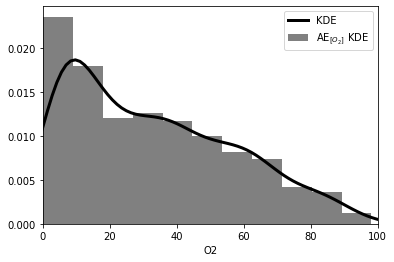

In [143]:
sns.distplot(np.abs(random_predictions - targets_dev['O2'])*100, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})
plt.xlim(0, 100)
plt.show()

# Result plots vs. number of removed frequency points

In [204]:
MAEO2 = [0.28, 0.28, 0.48 ,0.47, 1.12, 1.42, 2.07  ,4.9,4.7,5.5]
x = [0, 5,7, 10,15,20,22, 25,35,45]

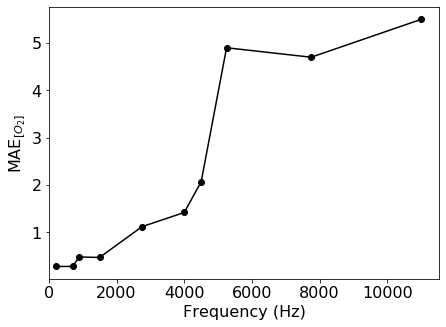

In [233]:
wremoved = [wred[i] for i in x]
fig = plt.figure(figsize = (7,5))

plt.plot(wremoved, MAEO2, marker = 'o', color = 'black', ls = '-')
plt.tick_params(labelsize=16)
plt.xlabel('Frequency (Hz)', fontsize = 16)
plt.ylabel(r'MAE$_{[O_2]}$', fontsize = 16)
plt.xlim(0,None)
#plt.show()
fig.savefig('../paper/Frequency_points_removal.svg', format='svg', dpi=300)
fig.savefig('../paper/Frequency_points_removal.eps', format='eps', dpi=300)


In [183]:
wred

[200.0,
 300.0,
 400.0,
 500.0,
 600.0,
 700.0,
 800.0,
 900.0,
 1000.0,
 1250.0,
 1500.0,
 1750.0,
 2000.0,
 2250.0,
 2500.0,
 2750.0,
 3000.0,
 3250.0,
 3500.0,
 3750.0,
 4000.0,
 4250.0,
 4500.0,
 4750.0,
 5000.0,
 5250.0,
 5500.0,
 5750.0,
 6000.0,
 6250.0,
 6500.0,
 6750.0,
 7000.0,
 7250.0,
 7500.0,
 7750.0,
 8000.0,
 8250.0,
 8500.0,
 8750.0,
 9000.0,
 9250.0,
 9500.0,
 9750.0,
 10000.0,
 11000.0,
 12000.0,
 13000.0,
 14000.0,
 15000.0]

# KDE Plots

<Figure size 432x288 with 0 Axes>

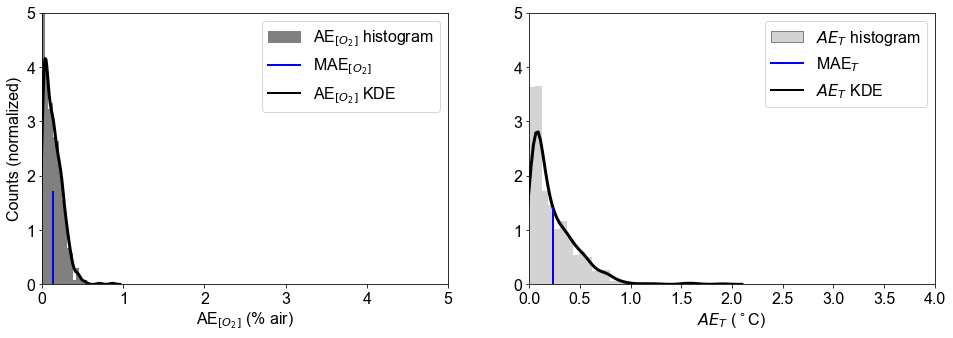

In [185]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat_3, color = 'gray', hist = True, label = 'AE$_{[O_2]}$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "gray"})


custom_lines = [Patch(facecolor='gray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['AE$_{[O_2]}$ histogram', 'MAE$_{[O_2]}$', 'AE$_{[O_2]}$ KDE'], fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 5)
plt.xlim(0, 5)

m_ = np.mean(MAE_boxplot_C_flat_3)

plt.plot([m_, m_], [0, 1.7], lw = 2, color = 'blue')


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat_3,   hist = True, label = '$AE_T$ KDE',rug_kws={"color": "gray"},
                  kde_kws={"color": "k", "lw": 3, "label": "KDE"},
                   hist_kws={"histtype": "bar", "linewidth": 0,
                             "alpha": 1, "color": "lightgray"})
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('$AE_T$ ($^\circ$C)', fontsize = 16)
plt.tick_params(labelsize=16)

custom_lines = [Patch(facecolor='lightgray', edgecolor='gray',
                         label='$AE_T$ KDE'),
                Line2D([0], [0], color='blue', lw=2),
                Line2D([0], [0], color='black', lw=2)
                ]

ax.legend(custom_lines, ['$AE_T$ histogram', 'MAE$_T$', '$AE_T$ KDE'], fontsize = 16)
#ax.legend( fontsize = 16)
plt.ylim(0, 5.0)
plt.xlim(0, 4)

m_ = np.mean(MAET_boxplot_C_MTL_flat_3)

plt.plot([m_, m_], [0, 1.4], lw = 2, color = 'blue')


plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('../paper/model_20001_32_1e-3_4x50_3x15_3x15_theta90.eps', format='eps', dpi=300,bbox_inches='tight')

# VERSIONS

In [83]:
#import tensorflow as tf
#from tensorflow.keras import layers

print(tf.__version__)
print(tf.keras.__version__)

2.1.0-rc1
2.2.4-tf
